In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d

In [5]:
####################################################################################################
# watermaze module
####################################################################################################
class watermaze(object):
    
    """
    This class defines a set of functions for simulating a rat moving in a water-maze.
    
    For the purposes of this assignment, you should be using the move function to 
    determine the next state of the environment at each time-step of the simulation.
    
    See the demo of its usage after the module code.
    """
    
    ####################################################################
    # the initialization function, measurements are in cm
    def __init__(self, pool_radius=60, platform_radius=10, platform_location=np.array([25,25]), 
                 stepsize=5.0, momentum=0.2, T=60):
        
        """
        The init function for the watermaze module.
        
        - The pool_radius argument specifies the radius of the pool.
        
        - The platform_radius argument specifies the radius of the platform.
        
        - The platform_location argument specifies the location of the platform centre.
        
        - The stepsize argument specifies how far the rat moves in one step.
        
        - The momentum argument specifies the ratio of old movement to new movement direction (i.e. 
        momentum = 0 means all new movement, momentum = 1 means all old movement, otherwise a mix.
        
        - The T argument is the maximum time for a trial in the pool.

        
        """
        
        # store the given info
        self.radius            = pool_radius
        self.platform_radius   = platform_radius
        self.platform_location = platform_location
        self.stepsize          = stepsize
        self.momentum          = momentum
        self.T                 = T
        
        # a dictionary for calculating directions
        self.direction = {
            0:  np.pi/2, #north
            1:  np.pi/4, #north-east
            2:  0, #east
            3:  7*np.pi/4, #south-east
            4:  3*np.pi/2, #south
            5:  5*np.pi/4, #south-west
            6:  np.pi, #west
            7:  3*np.pi/4, #north-west
        }
        
        # initialize the dynamic variables
        self.position = np.zeros((2,T))
        self.t        = 0
        self.prevdir  = np.zeros((2,))
        
    ####################################################################
    # for updating the rat's position in the pool
    def move(self, A):

        """
        Updates the simulated rat's position in the water-maze environment by moving it in the 
        specified direction. 
        
        - The argument A is the last selected action, and must be an integer from 0-7, with 0 indicating N, 
        1 indicating NE, etc. 

        """
        
        # check the A argument
        if (not np.isin(A, np.arange(8))):
            print('Error: The argument A must be an integer from 0-7, indicating which action was selected.')

        # determine the vector of direction of movement
        angle = self.direction[A]
        newdirection = np.array([np.cos(angle), np.sin(angle)])
        
        # add in momentum to reflect actual swimming dynamics (and normalize, then multiply by stepsize)
        direction = (1.0 - self.momentum)*newdirection + self.momentum*self.prevdir
        direction = direction/np.sqrt((direction**2).sum())
        direction = direction*self.stepsize
        
        # update the position, prevent the rat from actually leaving the water-maze by having it "bounce" off the wall 
        [newposition, direction] = self.poolreflect(self.position[:,self.t] + direction)

        # if we're now at the very edge of the pool, move us in a little-bit
        if (np.linalg.norm(newposition) == self.radius):
            newposition = np.multiply(np.divide(newposition,np.linalg.norm(newposition)),(self.radius - 1))

        # update the position, time (and previous direction)
        self.position[:,self.t+1] = newposition
        self.t                    = self.t + 1
        self.prevdir              = direction
        
    ####################################################################
    # for bouncing the rat off the wall of the pool
    def poolreflect(self, newposition):
        
        """
        The poolreflect function returns the point in space at which the rat will be located if it 
        tries to move from the current position to newposition but bumps off the wall of the pool. 
        If the rat would not bump into the wall, then it simply returns newposition. The function 
        also returns the direction the rat will be headed.
        """

        # determine if the newposition is outside the pool, if not, just return the new position
        if (np.linalg.norm(newposition) < self.radius):
            refposition  = newposition
            refdirection = newposition - self.position[:,self.t]

        else:

            # determine where the rat will hit the pool wall
            px = self.intercept(newposition)
            
            # get the tangent vector to this point by rotating -pi/2
            tx = np.asarray(np.matmul([[0, 1], [-1, 0]],px))

            # get the vector of the direction of movement
            dx = px - self.position[:,self.t]
            
            # get the angle between the direction of movement and the tangent vector
            theta = np.arccos(np.matmul((np.divide(tx,np.linalg.norm(tx))).transpose(),(np.divide(dx,np.linalg.norm(dx))))).item()

            # rotate the remaining direction of movement vector by 2*(pi - theta) to get the reflected direction
            ra = 2*(np.pi - theta)
            refdirection = np.asarray(np.matmul([[np.cos(ra), -np.sin(ra)], [np.sin(ra), np.cos(ra)]],(newposition - px)))

            # get the reflected position
            refposition = px + refdirection

        # make sure the new position is inside the pool
        if (np.linalg.norm(refposition) > self.radius):
            refposition = np.multiply((refposition/np.linalg.norm(refposition)),(self.radius - 1))

        return [refposition, refdirection]
    
    ####################################################################
    # for checking when/where the rat hits the edge of the pool
    def intercept(self,newposition):
        
        """
        The intercept function returns the point in space at which the rat will intercept with the pool wall 
        if it is moving from point P1 to point P2 in space, given the pool radius.
        """
        
        # for easy referencing, set p1 and p2
        p1 = self.position[:,self.t]
        p2 = newposition

        # calculate the terms used to find the point of intersection
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        dr = np.sqrt(np.power(dx,2) + np.power(dy,2))
        D  = p1[0]*p2[1] - p2[0]*p1[1]
        sy = np.sign(dy)
        if (sy == 0):
            sy = 1.0
            
        # calculate the potential points of intersection
        pp1 = np.zeros((2,))
        pp2 = np.zeros((2,))

        pp1[0] = (D*dy + sy*dx*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp2[0] = (D*dy - sy*dx*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp1[1] = (-D*dx + np.absolute(dy)*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp2[1] = (-D*dx - np.absolute(dy)*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))

        # determine which intersection point is actually the right one (whichever is closer to p2)
        if np.linalg.norm(p2 - pp1) < np.linalg.norm(p2 - pp2):
            px = pp1

        else:
            px = pp2
        
        return px
    
    ####################################################################
    # sets the start position of the rat in the pool
    def startposition(self):

        # select a random location from the main cardinal axes and calculate it's vector angle
        condition = 2*np.random.randint(0,4)
        angle = self.direction[condition]

        self.position[:,0] = np.asarray([np.cos(angle), np.sin(angle)]) * (self.radius - 1)
        
    ####################################################################
    # plot the most recent path of the rat through the pool
    def plotpath(self):
        
        # create the figure 
        fig = plt.figure()
        ax = fig.gca()

        # create the pool perimeter
        pool_perimeter = plt.Circle((0, 0), self.radius, fill=False, color='b', ls='-')
        ax.add_artist(pool_perimeter)

        # create theplatform
        platform = plt.Circle(self.platform_location, self.platform_radius, fill=False, color='r', ls='-')
        ax.add_artist(platform)

        # plot the path
        plt.plot(self.position[0,0:self.t],self.position[1,0:self.t], color='k', ls='-')

        # plot the final location and starting location
        plt.plot(self.position[0,0],self.position[1,0],color='b', marker='o',markersize=4, markerfacecolor='b')
        plt.plot(self.position[0,self.t-1],self.position[1,self.t-1],color='r', marker='o',markersize=6, markerfacecolor='r')

        # adjust the axis
        ax.axis('equal')
        ax.set_xlim((-self.radius-50, self.radius+50))
        ax.set_ylim((-self.radius-50, self.radius+50))
        plt.xticks(np.arange(-self.radius, self.radius+20, step=20))
        plt.yticks(np.arange(-self.radius, self.radius+20, step=20))
        ax.set_xlabel('X Position (cm)')
        ax.set_ylabel('Y Position (cm)')

        # turn on the grid
        plt.grid(True)
        plt.tight_layout()

        # show the figure
        plt.show()
        
    ####################################################################
    # checks whether the time is up
    def timeup(self):
        
        """
        Returns true if the time for the trial is finished, false otherwise.
        """
        
        return self.t > (self.T - 2)
    
    ####################################################################
    # checks whether the rat has found the platform
    def atgoal(self):
        
        """
        Returns true if the rat is on the platform, false otherwise.
        """
        
        return np.sqrt(np.sum((self.position[:,self.t] - self.platform_location)**2)) <= (self.platform_radius + 1)

## Actor-Critic Model

In [58]:
class PlaceCell(object):
        """
        This class represents one place cell
        """
        
        def __init__(self, center=np.array([0,0]), field_breadth=16):
            """
            - center is the position of the center of this place cell
            
            - field_breadth is the area around the center for which this place cell fires. We
            default this to 16cm since that is what is used in the Morris (2000) paper
            """
            
            self.center = center
            self.field_breadth = field_breadth
            
        def activity_for_position(self, position = np.array([0,0])):
            """
            Calculates the activity given the position for this particular place cell.
            """
            return np.exp(-(np.linalg.norm(position - self.center)**2)/(2*(self.field_breadth**2)))

class PlaceCellPopulation(object):
    """
    This class maintains a population of place cells for a given environment
    """
            
    
    def __init__(self, population_num=493, env_radius=60):
        """
        - population_num is the number of place cells
        - env_radius is the radius of the environment in which these place cells will be placed
        """
        self.population_num = population_num
        self.env_radius = env_radius
        
        self.place_cells_population = self.initPopulation(self.env_radius)
        
    def initPopulation(self, env_radius):
        """
        Initializes a population of place cells based on the population number centered uniformly in the environment
        
        Returns a list of place cell objects.
        
        - env_radius is the radius of the environment centered at 0,0 in which the population is being initialized
        """
        # generate uniformly distributed vectors from the center of the environment to point to a position
        
        # First generate lengths of the vectors away from center at which place cells could be placed
        position_vector_length = np.random.uniform(0, env_radius, self.population_num)
        
        # Generate the angle at which the position vector is pointing at uniformly between 0 radians and 2pi radians
        position_vector_angles = np.random.uniform(0, 2*np.pi, self.population_num)
        
        # Zip vector lengths and angles to generate a list of (length, angle)
        position_vectors = zip(position_vector_length, position_vector_angles)
        
        #Create and return list of place cell objects centered at the uniformly distributed positions
        return [PlaceCell(norm * np.array([math.cos(angle), math.sin(angle)])) for (norm,angle) in position_vectors]
        
    
    def activities_for_position(self, position = np.array([0,0])):
        """
        Returns a list of the activities for all the place cells for a given position
        """
        
        return [placeCell.activity_for_position(position) for placeCell in self.place_cells_population]

In [64]:
placecells = PlaceCellPopulation(population_num=2)
positions = [place.center for place in placecells.place_cells_population]
print(positions)
activations = placecells.activities_for_position(np.array([0,0]))
print('activations', activations)


[array([3.94807212, 2.9461971 ]), array([  6.68176105, -21.83118448])]
activations [0.9537085383100385, 0.3612952958870769]


In [ ]:
class Actor(object):
    """
    This class contains the actor logic of a model
    """
    
    def __init__(self):
        pass

In [ ]:
class Critic(object):
    """
    This class contains the critic logic of a model
    """
    
    def __init__(self):
        pass

In [ ]:
class ActorCriticModel(object):
    """
    This class puts everything together in order to maintain a model that can provide new actions and learn from them
    """
    
    def __init__(self):
        pass

## Experiment


In [16]:
class WatermazeExperiment(object):
    
    """
    This class takes care of coordinating the experiment and produce the plots as shown in the Morris (2000) paper.
    """
    
    def __init__(self, num_days=7, num_trials_per_day=4):
        
        """
        The init function for the experiment module.
        
        - num_trials_per_day is the number of trials we are doing per day.
        - num_days is over how many days we are conducting the experiment.
        """
        
        self.num_trials_per_day = num_trials_per_day
        self.num_days = num_days
        
        """
        Data structures to hold the information of the different runs
        """
        # Holds the watermaze objects for a run. Allows access of the watermaze for a given [day][trialNumber]
        self.exp_mazes = [[0 for trials in range(self.num_trials_per_day)] for days in range(self.num_days)]
    
    def run(self):
        """
        Runs the experiment.
        """
        for day in range(self.num_days):
            for trial in range(self.num_trials_per_day):
                maze = watermaze()
                
                # Store the maze for future reference
                self.exp_mazes[day][trial] = maze
                
                self.runMaze(maze)
        pass
    
    def runMaze(self, maze):
        maze.startposition()
        
        while(not maze.timeup() and not maze.atgoal()):
            
            #Select action
            A = np.random.randint(0,8)
            
            #move in the maze
            maze.move(A)
            
            #learn from this move
    
    def plotPaths(self):
        """
        Plots the paths of all of the runs in the experiment
        """
        for day in range(self.num_days):
            for trial in range(self.num_trials_per_day):
                
                maze_for_trial = self.exp_mazes[day][trial]
                maze_for_trial.plotpath()
        
    
    def plotPerformance(self):
        """
        Plots the performance in terms of time taken to get to the goal over the trial days.
        """
        pass
    
    def callForAllTrials(self, func):
        """
        Calls the function func sent in the argument for each trial in the experiment
        
        - func: function to be called in the form of func(day, trial)
        """
        
        
                

[[0, 0]]
[[<__main__.watermaze object at 0x0000019224216F08>, <__main__.watermaze object at 0x0000019223E42988>]]


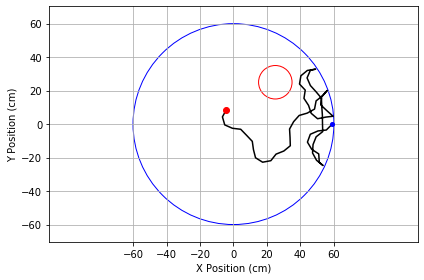

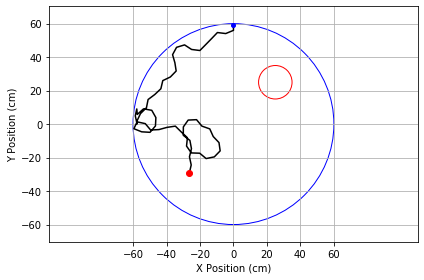

In [17]:
experiment = WatermazeExperiment(1,2)
print(experiment.exp_mazes)
experiment.run()
print(experiment.exp_mazes)
experiment.plotPaths()

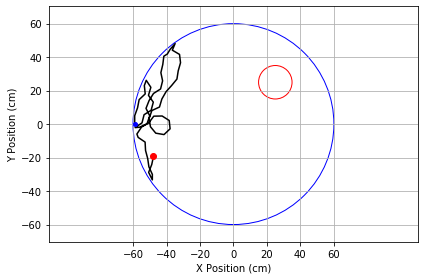

No more time for you dumb-dumb...


In [3]:
# demo of how to use the watermaze module

# create the watermaze object
maze = watermaze()

# set the starting location
maze.startposition()

# run forward for one trial (using random actions for sake of illustration)
while(not maze.timeup() and not maze.atgoal()):
    
    # select a random action - this is what your actor critic network needs to provide
    A = np.random.randint(0,8)
    
    # move the rat
    maze.move(A)
    
# plot the path
maze.plotpath()

# print out why the trial ended (note, if the rat reached the goal, then you must deliver a reward)
if maze.atgoal():
    print("Clever rat, you found the platform in",maze.t,"seconds!")
else:
    print("No more time for you dumb-dumb...")